In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rc('text', usetex=True)
import matplotlib
font = {'size'   : 18}
matplotlib.rc('font', **font)

import time
import numpy as np
from numpy import random as rand
from scipy import stats
import pandas as pd
import statsmodels.api as sm
import warnings

In [2]:
## The following are helper functions -- generally these should be used as is

In [7]:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        stats.alpha,stats.anglit,stats.arcsine,stats.beta,stats.betaprime,stats.bradford,stats.burr,stats.cauchy,stats.chi,stats.chi2,stats.cosine,
        stats.dgamma,stats.dweibull,stats.erlang,stats.expon,stats.exponnorm,stats.exponweib,stats.exponpow,stats.f,stats.fatiguelife,stats.fisk,
        stats.foldcauchy,stats.foldnorm,stats.frechet_r,stats.frechet_l,stats.genlogistic,stats.genpareto,stats.gennorm,stats.genexpon,
        stats.genextreme,stats.gausshyper,stats.gamma,stats.gengamma,stats.genhalflogistic,stats.gilbrat,stats.gompertz,stats.gumbel_r,
        stats.gumbel_l,stats.halfcauchy,stats.halflogistic,stats.halfnorm,stats.halfgennorm,stats.hypsecant,stats.invgamma,stats.invgauss,
        stats.invweibull,stats.johnsonsb,stats.johnsonsu,stats.ksone,stats.kstwobign,stats.laplace,stats.levy,stats.levy_l,stats.levy_stable,
        stats.logistic,stats.loggamma,stats.loglaplace,stats.lognorm,stats.lomax,stats.maxwell,stats.mielke,stats.nakagami,stats.ncx2,stats.ncf,
        stats.nct,stats.norm,stats.pareto,stats.pearson3,stats.powerlaw,stats.powerlognorm,stats.powernorm,stats.rdist,stats.reciprocal,
        stats.rayleigh,stats.rice,stats.recipinvgauss,stats.semicircular,stats.t,stats.triang,stats.truncexpon,stats.truncnorm,stats.tukeylambda,
        stats.uniform,stats.vonmises,stats.vonmises_line,stats.wald,stats.weibull_min,stats.weibull_max,stats.wrapcauchy
    ]

    DISTRIBUTIONS = [
        stats.beta,
        stats.cauchy,
        stats.chi,
        stats.chi2,
        stats.cosine,
        stats.dweibull,
        stats.expon,
        stats.exponnorm,
        stats.exponweib,
        stats.exponpow,
        stats.f,
        stats.fatiguelife,
        stats.fisk,
        stats.logistic,
        stats.loggamma,
        stats.loglaplace,
        stats.lognorm,
        stats.powerlaw,
        stats.norm,
        stats.powerlognorm,
        stats.powernorm,
        stats.truncexpon,
        stats.truncnorm,
        stats.uniform,
        stats.triang,
        stats.vonmises,
        stats.vonmises_line,
    ]

    # holder for Best holders -- only 
    best_distribution = stats.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                except Exception as e:
                    print(e)
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception as e:
            print(e)
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

Text(0, 0.5, 'Frequency')

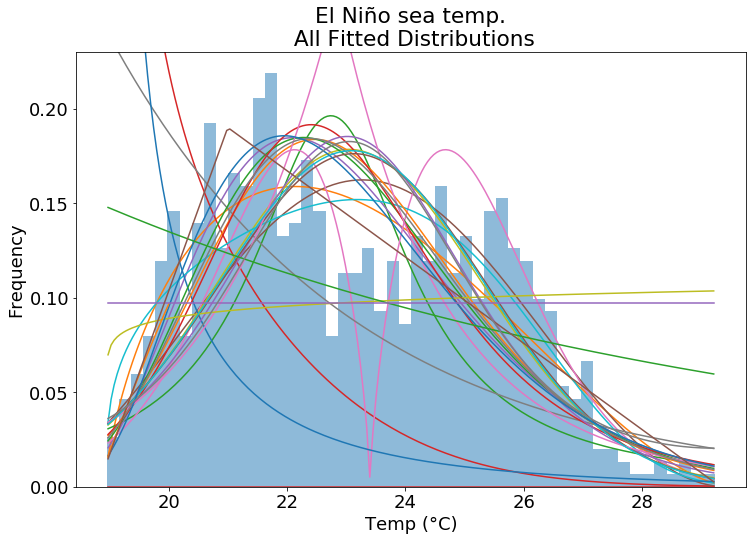

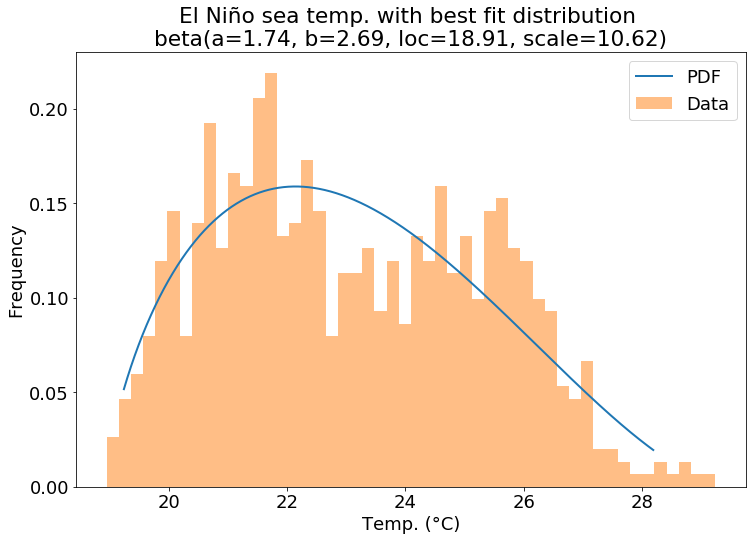

In [8]:
# Load data from statsmodels datasets
data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5) #, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(stats, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')